В данном проекте нужно было построить модель для определения стоимости автомобиля для сервиса продажи машин. Для реализации применялись библиотеки LightGBM и CatBoost.


# 1. Подготовка данных

In [222]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import lightgbm as lgm
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
import copy
import time
autos = pd.read_csv('/datasets/autos.csv')

In [223]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [224]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [225]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Удалим не нужные колонки и отдельно выделим категориальные:

In [226]:
autos.columns = ['DateCrawled', 'Price', 'VehicleType_cat', 'RegistrationYear', 'Gearbox_cat',
       'Power', 'Model_cat', 'Kilometer', 'RegistrationMonth', 'FuelType_cat', 'Brand_cat',
       'Repaired_cat', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen']

autos = autos.drop(['DateCrawled','DateCreated','LastSeen','NumberOfPictures', 'PostalCode'], axis=1)

category_columns = ['VehicleType_cat', 'Gearbox_cat', 'Model_cat', 'FuelType_cat',
           'Brand_cat', 'RegistrationMonth_cat', 'Repaired_cat']

In [227]:
all_nan = autos.isna().sum()
all_nan

Price                    0
VehicleType_cat      37490
RegistrationYear         0
Gearbox_cat          19833
Power                    0
Model_cat            19705
Kilometer                0
RegistrationMonth        0
FuelType_cat         32895
Brand_cat                0
Repaired_cat         71154
dtype: int64

In [228]:
perc_nan = all_nan / autos.shape[0]
perc_nan.sort_values(ascending=False)

Repaired_cat         0.200791
VehicleType_cat      0.105794
FuelType_cat         0.092827
Gearbox_cat          0.055967
Model_cat            0.055606
Brand_cat            0.000000
RegistrationMonth    0.000000
Kilometer            0.000000
Power                0.000000
RegistrationYear     0.000000
Price                0.000000
dtype: float64

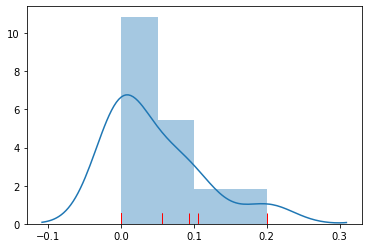

In [229]:
sns.distplot(perc_nan, rug=True, rug_kws={"color": "r"})

In [230]:
autos.dropna(subset=['VehicleType_cat', 'Gearbox_cat', 'Model_cat', 'FuelType_cat', 'Repaired_cat'], inplace=True)

In [231]:
autos.duplicated().sum()

21054

In [232]:
autos[autos.duplicated()]

,Price,VehicleType_cat,RegistrationYear,Gearbox_cat,Power,Model_cat,Kilometer,RegistrationMonth,FuelType_cat,Brand_cat,Repaired_cat
3551,1670,sedan,1999,manual,75,golf,150000,8,petrol,volkswagen,no
3786,2999,sedan,2002,manual,101,golf,150000,6,gasoline,volkswagen,no
3907,500,small,1999,manual,55,corsa,150000,12,petrol,opel,no
4134,18750,sedan,2014,manual,150,golf,20000,9,gasoline,volkswagen,no
4222,14500,wagon,2007,manual,140,a6,100000,3,gasoline,audi,no
...,...,...,...,...,...,...,...,...,...,...,...
354325,12800,convertible,1991,manual,211,other,150000,7,petrol,porsche,no
354333,13850,wagon,2012,manual,156,accord,125000,10,petrol,honda,no
354352,6500,sedan,2003,auto,145,e_klasse,150000,3,gasoline,mercedes_benz,no
354355,4400,sedan,2008,manual,105,leon,150000,7,gasoline,seat,no


дубликаты можно не трогать, так как их и так мало, они не повлияют ни на что.

In [233]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245814 entries, 3 to 354367
Data columns (total 11 columns):
Price                245814 non-null int64
VehicleType_cat      245814 non-null object
RegistrationYear     245814 non-null int64
Gearbox_cat          245814 non-null object
Power                245814 non-null int64
Model_cat            245814 non-null object
Kilometer            245814 non-null int64
RegistrationMonth    245814 non-null int64
FuelType_cat         245814 non-null object
Brand_cat            245814 non-null object
Repaired_cat         245814 non-null object
dtypes: int64(5), object(6)
memory usage: 22.5+ MB


In [234]:
autos['Repaired_cat'].value_counts()

no     217996
yes     27818
Name: Repaired_cat, dtype: int64

In [235]:
autos['VehicleType_cat'].value_counts()

sedan          72257
small          58929
wagon          51171
bus            23649
convertible    16207
coupe          12221
suv             9639
other           1741
Name: VehicleType_cat, dtype: int64

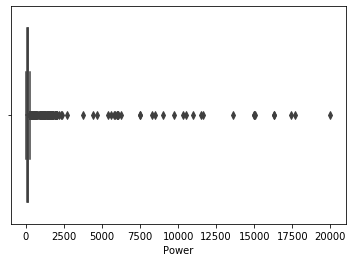

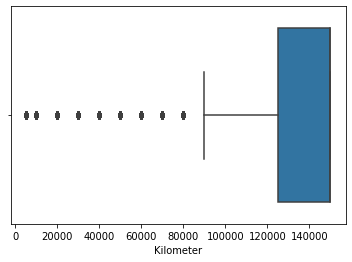

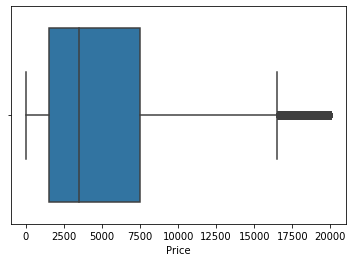

In [236]:

for a in ['Power','Kilometer','Price']:
    sns.boxplot(autos[a]) 
    plt.show()

Видим явные аномалии в цене, надо сделать по ним срез. И много нулевых значений с цене и мощности, их можно заменить средним значением. Сделаем сводные таблицы и в них заменим на средние, а затем применим их к основному датасету

In [237]:
autos = autos.query('Price < 14000')
autos = autos.query('Price != 1')
power_new = autos.pivot_table(columns='Model_cat', values='Power', aggfunc='mean').astype('int').to_dict()
price_new = autos.pivot_table(columns='Model_cat', values='Price', aggfunc='mean').astype('int').to_dict()

In [238]:
def fill_0(row, cat, place, table):
    a = row[cat]
    b = table[a][place]
    if row[place] == 0:  
        row[place] = b
    return row
        
autos = autos.apply(fill_0, axis=1, args=('Model_cat','Power', power_new))
autos = autos.apply(fill_0, axis=1, args=('Model_cat','Price', price_new))

autos.head(20)

,Price,VehicleType_cat,RegistrationYear,Gearbox_cat,Power,Model_cat,Kilometer,RegistrationMonth,FuelType_cat,Brand_cat,Repaired_cat
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
7,3956,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes
17,1750,small,2004,auto,75,twingo,150000,2,petrol,renault,no
18,7550,bus,2007,manual,136,c_max,150000,6,gasoline,ford,no
19,1850,bus,2004,manual,102,a_klasse,150000,1,petrol,mercedes_benz,no


отрежем цены ниже 100 евро и уберем нулевые значения мощностей

In [239]:
autos = autos.query('Power != 0')
autos = autos.query('Price > 100')

In [240]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227250 entries, 3 to 354367
Data columns (total 11 columns):
Price                227250 non-null int64
VehicleType_cat      227250 non-null object
RegistrationYear     227250 non-null int64
Gearbox_cat          227250 non-null object
Power                227250 non-null int64
Model_cat            227250 non-null object
Kilometer            227250 non-null int64
RegistrationMonth    227250 non-null int64
FuelType_cat         227250 non-null object
Brand_cat            227250 non-null object
Repaired_cat         227250 non-null object
dtypes: int64(5), object(6)
memory usage: 20.8+ MB


Данные готовы к построению моделей.

# 2. Обучение моделей

In [249]:
def time_score(model, features_train, target_train, features_test, target_test):
    
    start = time.time()    
    model.fit(features_train, target_train)
    train_time = time.time() - start
    
    start = time.time()  
    predict = model.predict(features_test)
    predict_time = time.time() - start

    return train_time, predict_time, mean_squared_error(target_test, predict)**0.5

Разделим датасет:

In [242]:
features = autos.drop(['Price'], axis = 1)  
target = autos['Price'] 

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, random_state=123)

In [243]:
features_train.shape[0], features_valid.shape[0], target_train.shape[0], target_valid.shape[0]

(181800, 45450, 181800, 45450)

In [244]:
features_train['VehicleType_cat'] = features_train['VehicleType_cat'].astype('category')
features_train['Gearbox_cat'] = features_train['Gearbox_cat'].astype('category')
features_train['Model_cat'] = features_train['Model_cat'].astype('category')
features_train['FuelType_cat'] = features_train['FuelType_cat'].astype('category')
features_train['Brand_cat'] = features_train['Brand_cat'].astype('category')
features_train['Repaired_cat'] = features_train['Repaired_cat'].astype('category')

features_valid['VehicleType_cat'] = features_valid['VehicleType_cat'].astype('category')
features_valid['Gearbox_cat'] = features_valid['Gearbox_cat'].astype('category')
features_valid['Model_cat'] = features_valid['Model_cat'].astype('category')
features_valid['FuelType_cat'] = features_valid['FuelType_cat'].astype('category')
features_valid['Brand_cat'] = features_valid['Brand_cat'].astype('category')
features_valid['Repaired_cat'] = features_valid['Repaired_cat'].astype('category')


In [245]:
category_features = [c for c, col in enumerate(features_train.columns) if '_cat' in col]
category_features

[0, 2, 4, 7, 8, 9]

In [207]:
%%time
estim = lgb.LGBMRegressor()
estim.fit(features_train, target_train, eval_metric='rmse', categorical_feature=category_features)
predicted_valid = estim.predict(features_valid)
predicted_train = estim.predict(features_train)
print('The rmse of LGBMRegressor prediction on train:', mean_squared_error(target_train, predicted_train) ** 0.5)
print('The rmse of LGBMRegressor prediction on valid:', mean_squared_error(target_valid, predicted_valid) ** 0.5)

The rmse of LGBMRegressor prediction on train: 1283.0923159094762
The rmse of LGBMRegressor prediction on valid: 1326.9973189931036
CPU times: user 32 s, sys: 265 ms, total: 32.3 s
Wall time: 32.5 s


# 3. Анализ моделей

Разброс значений цены между обучающей и валидационной выборках не сильно большой. Далее надо подобрать параметры для исследования модели с помощью GridSearchCV:

In [ ]:
%%time
estim_new = lgb.LGBMRegressor(num_leaves= 31,learning_rate=0.01)

param_grid = {
    'n_estimators': [10,50,100,200,250],
    'max_depth': [1,5,10,15,20]
   
}

cv =KFold(random_state=1, n_splits=7)
gbm = GridSearchCV(estim_new, param_grid, cv=cv, scoring='neg_mean_squared_error')

gbm.fit(features_train, target_train, categorical_feature=category_features)

print('Best parameters is:', gbm.best_params_)
print('Best score is:', gbm.best_score_)

Опять GridSearch работает так долго(((
В итоге имеем рекомендованные параметры 'max_depth': 15, 'n_estimators': 250, применим их на модели:

In [246]:
%%time
model = lgb.LGBMRegressor(num_leaves= 31, learning_rate=0.01, max_depth=15, n_estimators=250)
model.fit(features_train, target_train, categorical_feature=category_features)
predicted_valid1 = model.predict(features_valid)
rmse = (mean_squared_error(target_valid, predicted_valid1))**0.5

rmse

CPU times: user 24.1 s, sys: 159 ms, total: 24.2 s
Wall time: 24.5 s


1482.414678711415

In [250]:
result = []
result.append(time_score(model, features_train, target_train, features_valid, target_valid))

Обучим CatBoost:

In [251]:
%%time
model_cat = CatBoostRegressor(n_estimators = 200, loss_function = 'MAE', eval_metric = 'RMSE', cat_features = category_features)
model_cat.fit(features_train, target_train, cat_features=category_features, verbose=10)
predicted_valid2 = model_cat.predict(features_valid)
rmse = (mean_squared_error(target_valid, predicted_valid2))**0.5
rmse

0:	learn: 3602.1921444	total: 554ms	remaining: 1m 50s
10:	learn: 3000.9306102	total: 5.66s	remaining: 1m 37s
20:	learn: 2576.8172931	total: 11.4s	remaining: 1m 37s
30:	learn: 2280.6125156	total: 17s	remaining: 1m 32s
40:	learn: 2081.0182667	total: 22.5s	remaining: 1m 27s
50:	learn: 1943.0847937	total: 27.7s	remaining: 1m 20s
60:	learn: 1849.1223750	total: 33.3s	remaining: 1m 15s
70:	learn: 1773.0215630	total: 38.7s	remaining: 1m 10s
80:	learn: 1718.3031497	total: 44s	remaining: 1m 4s
90:	learn: 1676.3761737	total: 49.3s	remaining: 59s
100:	learn: 1642.7109979	total: 54.3s	remaining: 53.2s
110:	learn: 1614.4835649	total: 59.4s	remaining: 47.6s
120:	learn: 1595.4448505	total: 1m 4s	remaining: 41.9s
130:	learn: 1579.5175445	total: 1m 9s	remaining: 36.4s
140:	learn: 1564.3569602	total: 1m 14s	remaining: 31.1s
150:	learn: 1551.2641897	total: 1m 19s	remaining: 25.6s
160:	learn: 1539.3679548	total: 1m 24s	remaining: 20.4s
170:	learn: 1530.0969432	total: 1m 29s	remaining: 15.1s
180:	learn: 152

1524.5798763801724

In [252]:
result.append(time_score(model_cat, features_train, target_train, features_valid, target_valid))


0:	learn: 3602.1921444	total: 630ms	remaining: 2m 5s
1:	learn: 3531.0438967	total: 1.22s	remaining: 2m
2:	learn: 3461.8006944	total: 1.72s	remaining: 1m 52s
3:	learn: 3398.2073962	total: 2.21s	remaining: 1m 48s
4:	learn: 3334.8638758	total: 2.8s	remaining: 1m 49s
5:	learn: 3273.9041278	total: 3.22s	remaining: 1m 44s
6:	learn: 3214.9760633	total: 3.72s	remaining: 1m 42s
7:	learn: 3155.0278989	total: 4.31s	remaining: 1m 43s
8:	learn: 3101.4697422	total: 4.73s	remaining: 1m 40s
9:	learn: 3049.9245922	total: 5.29s	remaining: 1m 40s
10:	learn: 3000.9306102	total: 5.73s	remaining: 1m 38s
11:	learn: 2951.4144503	total: 6.41s	remaining: 1m 40s
12:	learn: 2900.0003619	total: 7.01s	remaining: 1m 40s
13:	learn: 2850.0527184	total: 7.52s	remaining: 1m 39s
14:	learn: 2802.6071203	total: 8.1s	remaining: 1m 39s
15:	learn: 2764.7724149	total: 8.62s	remaining: 1m 39s
16:	learn: 2725.9581903	total: 9.2s	remaining: 1m 39s
17:	learn: 2688.3563848	total: 9.79s	remaining: 1m 38s
18:	learn: 2650.5938726	tota

In [253]:
pd.DataFrame(data=result,
index=['LightGBM', 'CatBoost'],
columns=['Время_обучения', 'Время_Предсказания', 'RMSE'])

,Время_обучения,Время_Предсказания,RMSE
LightGBM,24.041236,2.103331,1482.414679
CatBoost,105.372883,0.048873,1524.579876



В итоге лучшей моделью стала LightGBM, скорость обучения у нее лучше. 